In [3]:
import mne
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from mne.preprocessing import ICA
import toml
import mne_bids
import re
from pathlib import Path
import matplotlib
import numpy as np
from ipywidgets import interact

mne.viz.set_browser_backend("qt")
mne.set_config('MNE_BROWSER_THEME', 'light')
# matplotlib.use("Agg")


config = toml.load("../../.env.toml")
project_path = config["project"]["path"]

This file contains preprocessing files after downsampling them.


In [4]:
subject = "101"
fname_path = f"{project_path}/data/raw/BIDS/sub-{subject}/ses-01/eeg/sub-{subject}_ses-01_task-rest_eeg.set"

## This part could be replaced by read MFF files (set files are just downsampled MFF files saved to the local laptop drive)

raw = mne.io.read_raw_eeglab(fname_path, preload=True)

# raw = mne.io.read_raw_egi(fname_path, preload=True)
ch_name_type = dict(zip(raw.ch_names, raw.get_channel_types()))

ch_name_ecg = [name for name in raw.ch_names if name in "ECG"]
dict_ecg = {sub[0]: "ecg" for sub in (ele.split() for ele in ch_name_ecg)}

raw.set_channel_types(dict_ecg)
montage = mne.channels.make_standard_montage("GSN-HydroCel-257")
raw.set_montage(montage, match_alias={"VREF": "Cz"})
raw.rename_channels({'VREF': 'Cz'})

raw_downsampled = (
    raw.copy().crop(tmin=0, tmax=300, include_tmax=True).resample(sfreq=128)
)

In [5]:
# detrending
from meegkit.detrend import detrend

raw_detrended = raw_downsampled.copy()
X = raw_detrended.get_data().T  # transpose so the data is organized time-by-channels
X, _, _ = detrend(X, order=1)
X, _, _ = detrend(X, order=6)
raw_detrended._data = X.T  # overwrite raw data


In [17]:


filter_params = {
    "l_freq": 0.5,
    "h_freq": 45,
    "h_trans_bandwidth": 5,
    "fir_design": "firwin2",
    "phase": "zero-double",
}
raw_filtered = raw_detrended.filter(**filter_params)  # removedrifts

In [18]:
raw_filtered_plot = mne.viz.plot_raw(raw_filtered, duration=10.0, scalings="auto",  n_channels=10)

2024-03-04 23:00:12,377 - qdarkstyle - INFO - QSS file successfully loaded.
2024-03-04 23:00:12,377 - qdarkstyle - INFO - Found OS patches to be applied.
2024-03-04 23:00:12,378 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-04 23:00:12,378 - qdarkstyle - INFO - Found application patches to be applied.


In [8]:
mne.set_log_level("WARNING")
from pyprep.prep_pipeline import PrepPipeline
sample_rate = raw_detrended.info["sfreq"]
# Fit prep
prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(50, sample_rate / 2, 50),
}

prep = PrepPipeline(raw_detrended, prep_params, montage)
prep.fit()

2024-03-04 22:38:38,263 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E100', 'E109', 'E110'], 'bad_by_hf_noise': ['E89', 'E90', 'E98', 'E99', 'E100', 'E101', 'E107', 'E108', 'E109', 'E110', 'E115', 'E116', 'E117'], 'bad_by_correlation': ['E9', 'E91', 'E132', 'E133', 'E145', 'E174', 'E188', 'E216', 'E217', 'E229', 'E251', 'E256'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['E101', 'E145', 'E100', 'E256', 'E99', 'E174', 'E107', 'E188', 'E108', 'E117', 'E251', 'E110', 'E116', 'E91', 'E229', 'Cz', 'E98', 'E132', 'E217', 'E89', 'E109', 'E115', 'E133', 'E216', 'E90', 'E9']}
2024-03-04 22:38:53,482 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E110', 'E109', 'E217', 'E100'], 'bad_by_hf_noise': ['E113', 'E101', 'E100', 'E99', 'E107', 'E188', 'E123', 'E108', 'E117', 'E121', 'E110', 'E114', 'E106', 'E116', 'E119', 'E98', 'E118', 'E89', 'E109', 'E11

In [9]:
mne.set_log_level("WARNING")
from pyprep.prep_pipeline import PrepPipeline
sample_rate = raw_downsampled.info["sfreq"]
# Fit prep
prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(50, sample_rate / 2, 50),
}

prep = PrepPipeline(raw_downsampled, prep_params, montage)
prep.fit()

2024-03-04 22:40:32,850 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E100', 'E109', 'E110'], 'bad_by_hf_noise': ['E89', 'E90', 'E98', 'E99', 'E100', 'E101', 'E107', 'E108', 'E109', 'E110', 'E115', 'E116', 'E117'], 'bad_by_correlation': ['E9', 'E91', 'E132', 'E133', 'E145', 'E174', 'E188', 'E216', 'E217', 'E229', 'E251', 'E256'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['E101', 'E145', 'E100', 'E256', 'E99', 'E174', 'E107', 'E188', 'E108', 'E117', 'E251', 'E110', 'E116', 'E91', 'E229', 'Cz', 'E98', 'E132', 'E217', 'E89', 'E109', 'E115', 'E133', 'E216', 'E90', 'E9']}
2024-03-04 22:40:56,360 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E110', 'E109', 'E217', 'E100'], 'bad_by_hf_noise': ['E113', 'E101', 'E100', 'E99', 'E107', 'E188', 'E123', 'E108', 'E117', 'E121', 'E110', 'E114', 'E106', 'E116', 'E119', 'E98', 'E118', 'E89', 'E109', 'E11

In [14]:
print("Bad channels: {}".format(prep.interpolated_channels))
print("Bad channels original: {}".format(prep.noisy_channels_original["bad_all"]))
print("Bad channels after interpolation: {}".format(prep.still_noisy_channels))

# Matlab's results
# ----------------
# Bad channels: Fc5, Fc3, Fc1, C3, Cp3, Cp4, Af3, Afz, Af8, F7, F5, F6, F8,
#               Ft8, P7, P2
# Bad channels original: Af3, Af4, Af7, Af8, Fp1, Fp2, Fpz, Ft8
# Bad channels after interpolation: Cp5, Fp2, Af7, F1

Bad channels: ['E91', 'E133', 'E113', 'E216', 'E145', 'E247', 'E117', 'E101', 'E114', 'E109', 'E100', 'E116', 'E107', 'E122', 'E108', 'E118', 'E123', 'E238', 'E217', 'E256', 'Cz', 'E110', 'E229', 'E97', 'E106', 'E98', 'E115', 'E99', 'E251']
Bad channels original: ['E91', 'E133', 'E216', 'E145', 'E132', 'E9', 'E90', 'E101', 'E117', 'E188', 'E109', 'E100', 'E116', 'E89', 'E107', 'E174', 'E108', 'E217', 'E256', 'Cz', 'E110', 'E229', 'E98', 'E115', 'E99', 'E251']
Bad channels after interpolation: []


In [20]:
raw_detrended.info["bads"] = prep.noisy_channels_original["bad_by_correlation"]
raw_detrended.info["bads"].extend(prep.noisy_channels_original["bad_by_flat"])

In [21]:
raw_detrended_plot = mne.viz.plot_raw(raw_detrended, duration=10.0, scalings="auto",  n_channels=10)

2024-03-04 23:04:40,980 - qdarkstyle - INFO - QSS file successfully loaded.
2024-03-04 23:04:40,994 - qdarkstyle - INFO - Found OS patches to be applied.
2024-03-04 23:04:40,994 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-04 23:04:40,995 - qdarkstyle - INFO - Found application patches to be applied.


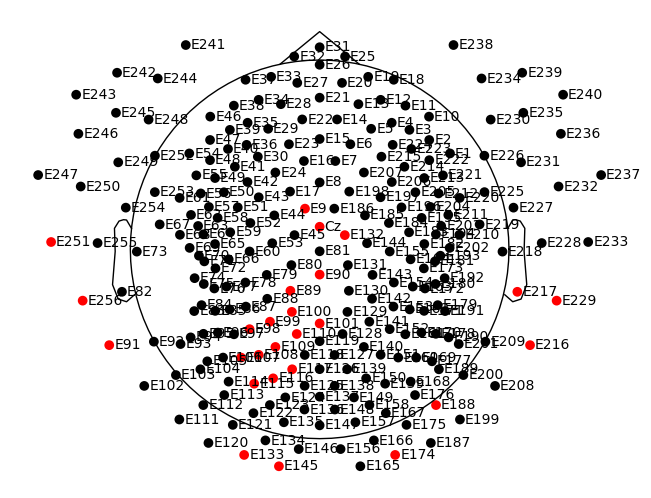

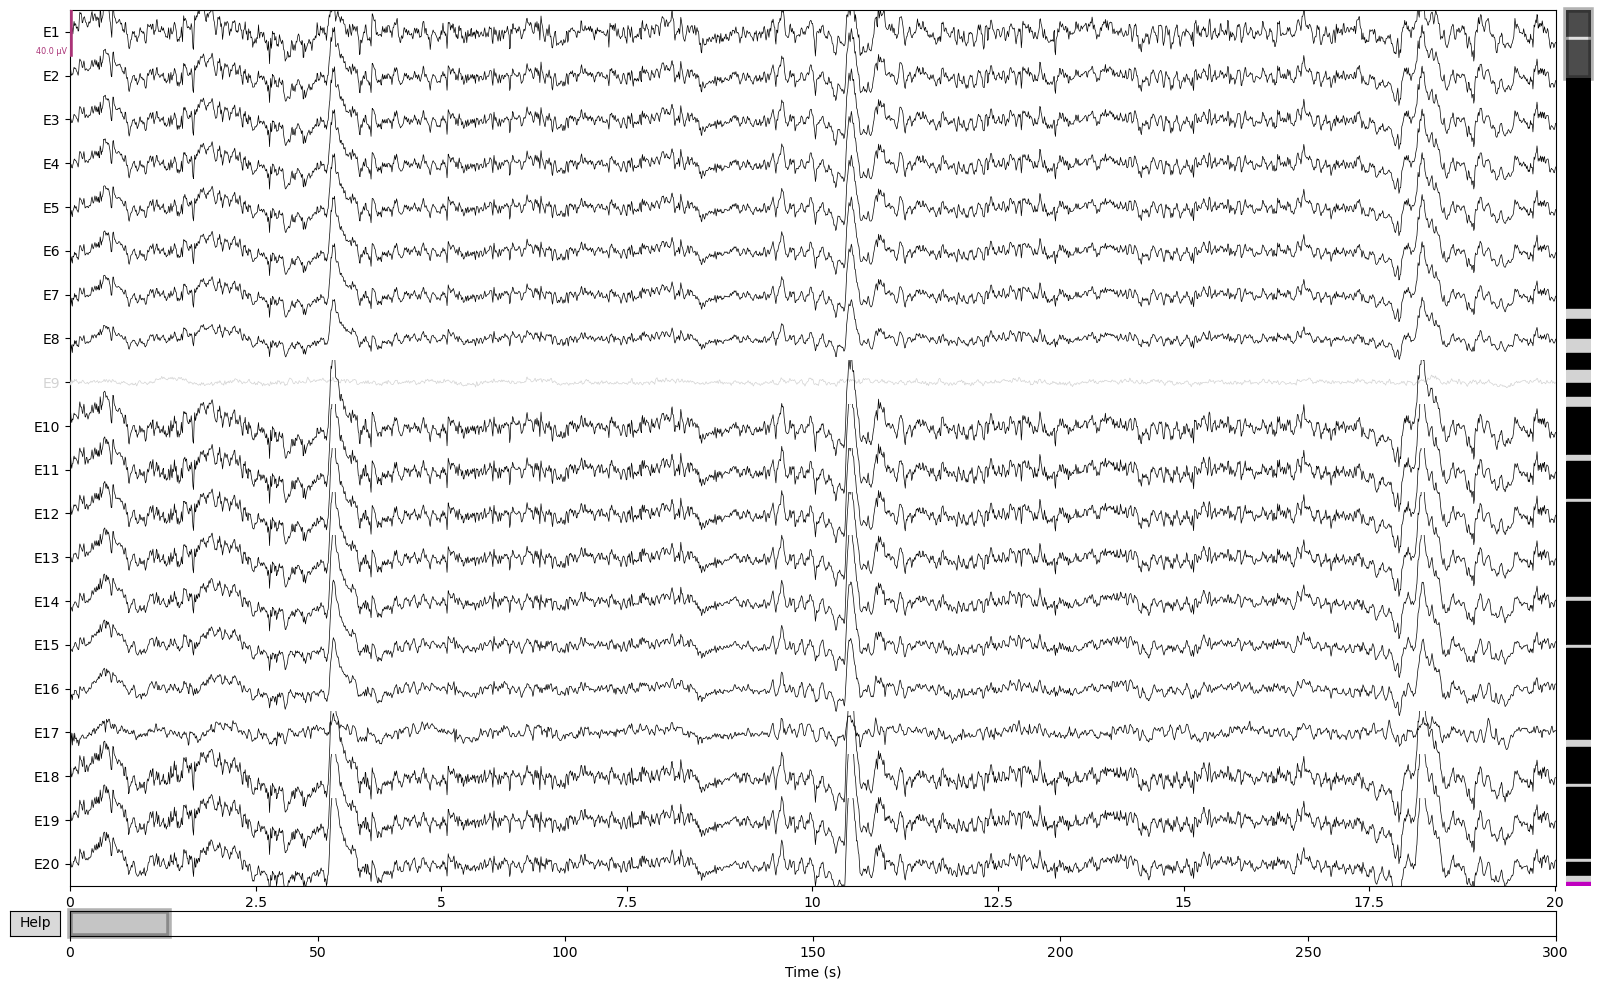

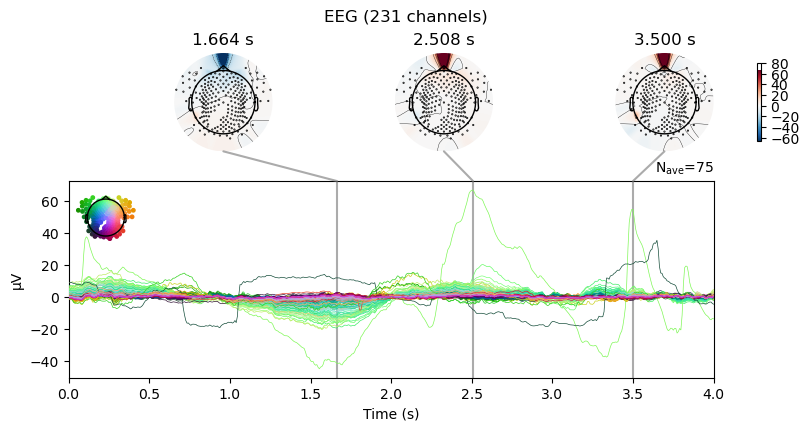

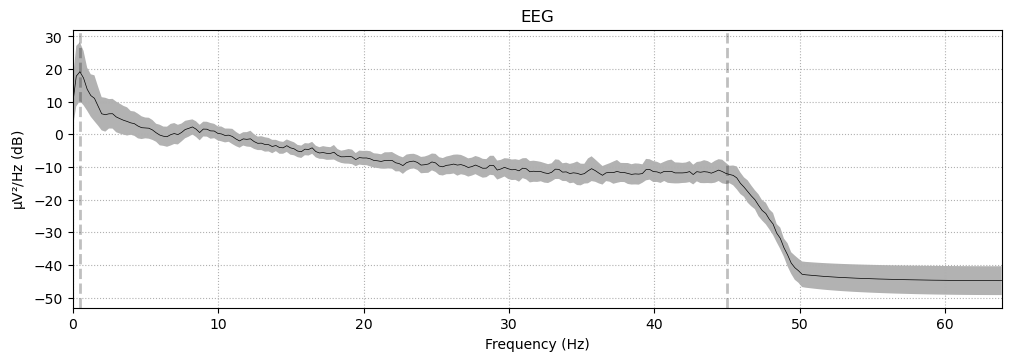

In [24]:


filter_params = {
    "l_freq": 0.5,
    "h_freq": 45,
    "h_trans_bandwidth": 5,
    "fir_design": "firwin2",
    "phase": "zero-double",
}
raw_filtered = raw_detrended.filter(**filter_params)  # removedrifts

# raw.info['line_freq'] = 50.
# freqs = (50, 100)
# eeg_picks = mne.pick_types(raw.info, eeg=True)

# raw_notch = raw_filtered.copy().notch_filter(freqs=freqs, picks=eeg_picks)
raw_filtered.plot_sensors(show_names=True)

raw_plot = mne.viz.plot_raw(raw_filtered, duration=20.0, , scalings="auto")

# epochs = mne.make_fixed_length_epochs(raw_filtered, duration=3, preload=True)
events = mne.make_fixed_length_events(
    raw=raw_filtered, start=0, stop=None, duration=4, overlap=0, first_samp=False
)

# Create  Epochs object
epochs = mne.Epochs(
    raw=raw_filtered,
    events=events,
    tmin=0,
    tmax=4,
    detrend=0,
    baseline=None,
    preload=True,
)
# plot the data
epochs_plot = epochs.copy().average().detrend().plot_joint()
epochs_plot_psd = epochs.compute_psd(method="welch", picks="eeg", exclude="bads").plot(
    average=True, picks="eeg", exclude="bads", show=False
)
# raw_plot.savefig(f"{project_path}/reports/figures/raw_plot.png")

# Removing the noise from the data


In [25]:
ar = autoreject.AutoReject(
    n_interpolate=[1, 2, 4, 8, 16, 32, 64, 128], random_state=11, n_jobs=1, verbose=True
)
ar.fit(epochs)  # fit on a few epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/autoreject/utils.py:73: UserWarning: 26 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


Running autoreject on ch_type=eeg


No projector specified for this dataset. Please consider the method self.add_proj.


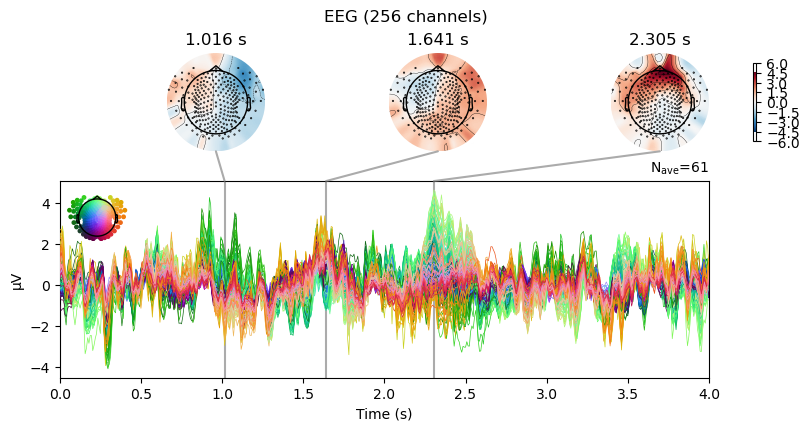

Effective window size : 4.008 (s)
Averaging across epochs...


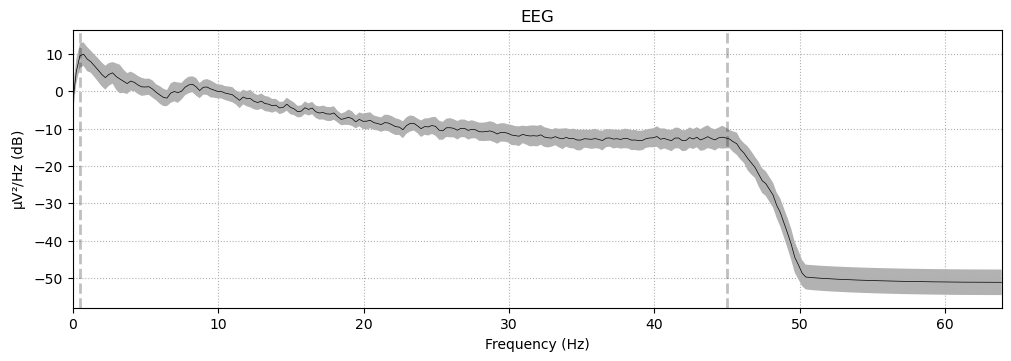

In [21]:
epoch_ar_plot = epochs_ar.copy().average().detrend().plot_joint()
epochs_ar_psd = epochs_ar.compute_psd(method="welch", picks="eeg", exclude="bads").plot(
    average=True, picks="eeg", exclude="bads", show=False
)

In [1]:
epochs_raw = epochs_ar.plot(n_epochs=30, n_channels=30, scalings=dict(eeg=20e-6))

NameError: name 'epochs_ar' is not defined

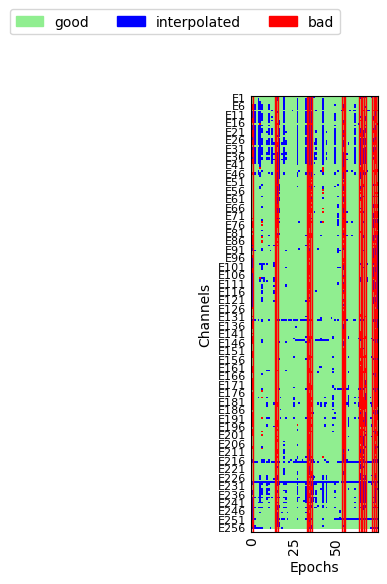

In [26]:
reject_plot = reject_log.plot(orientation="horizontal")

Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.5s
[Parallel(n_job

Fitting ICA to data using 256 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 15137 tasks      | elapsed:    4.0s


Selecting by explained variance: 36 components
Fitting ICA took 3.2s.


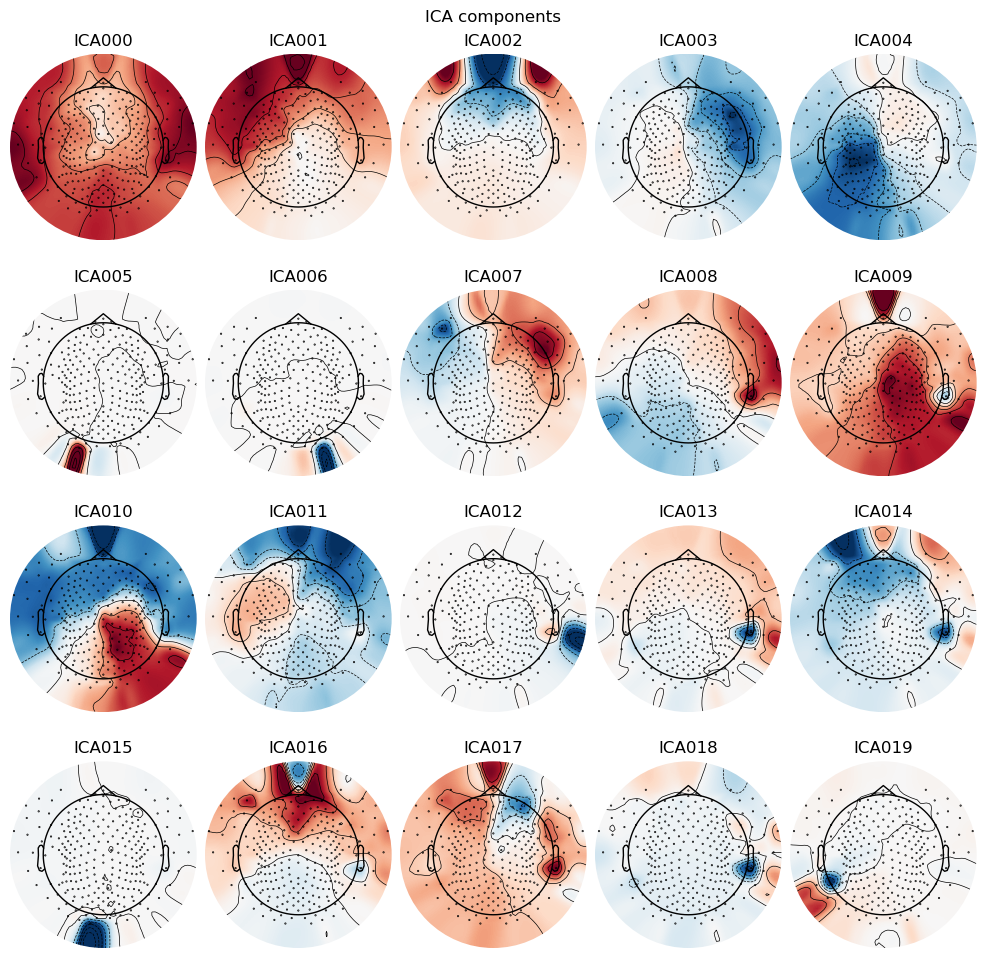

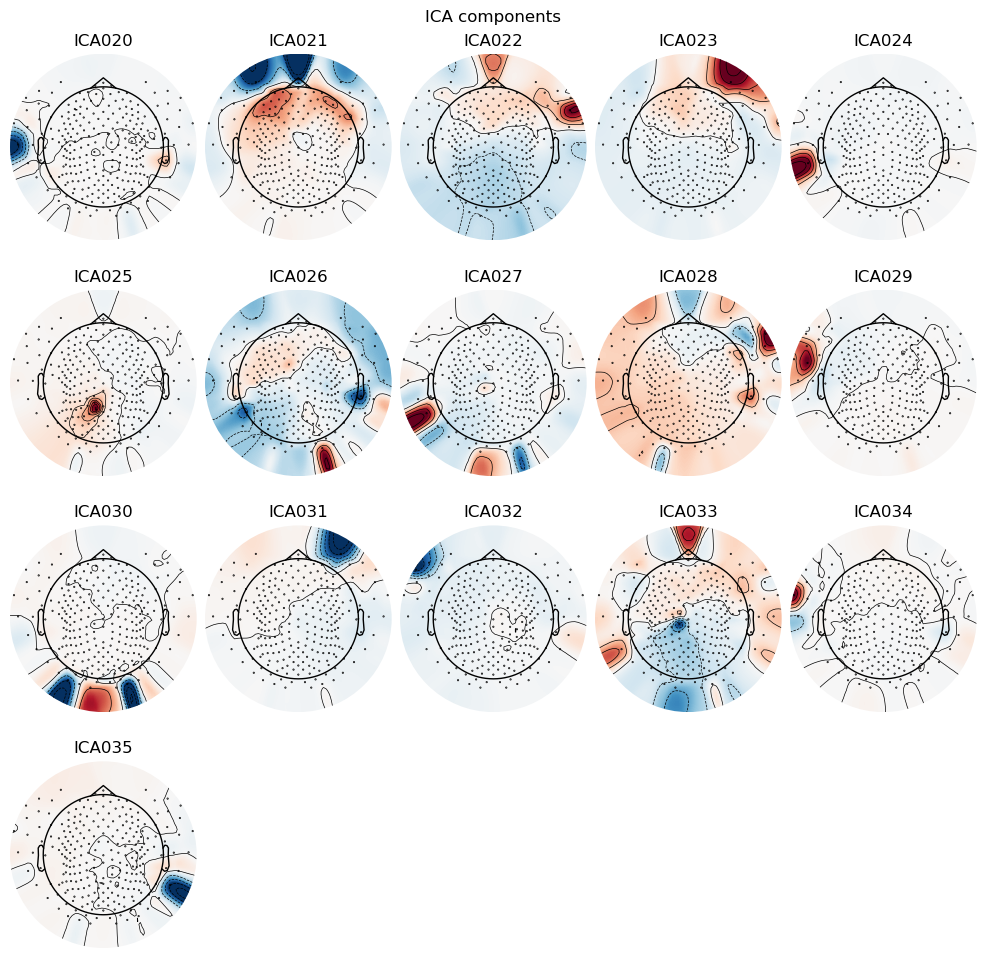

In [31]:
from mne.preprocessing import ICA

ica = ICA(n_components=0.99, random_state=99)
ica.fit(epochs[~reject_log.bad_epochs].copy().filter(l_freq=2, h_freq=None))
ica_plot = ica.plot_components()

Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


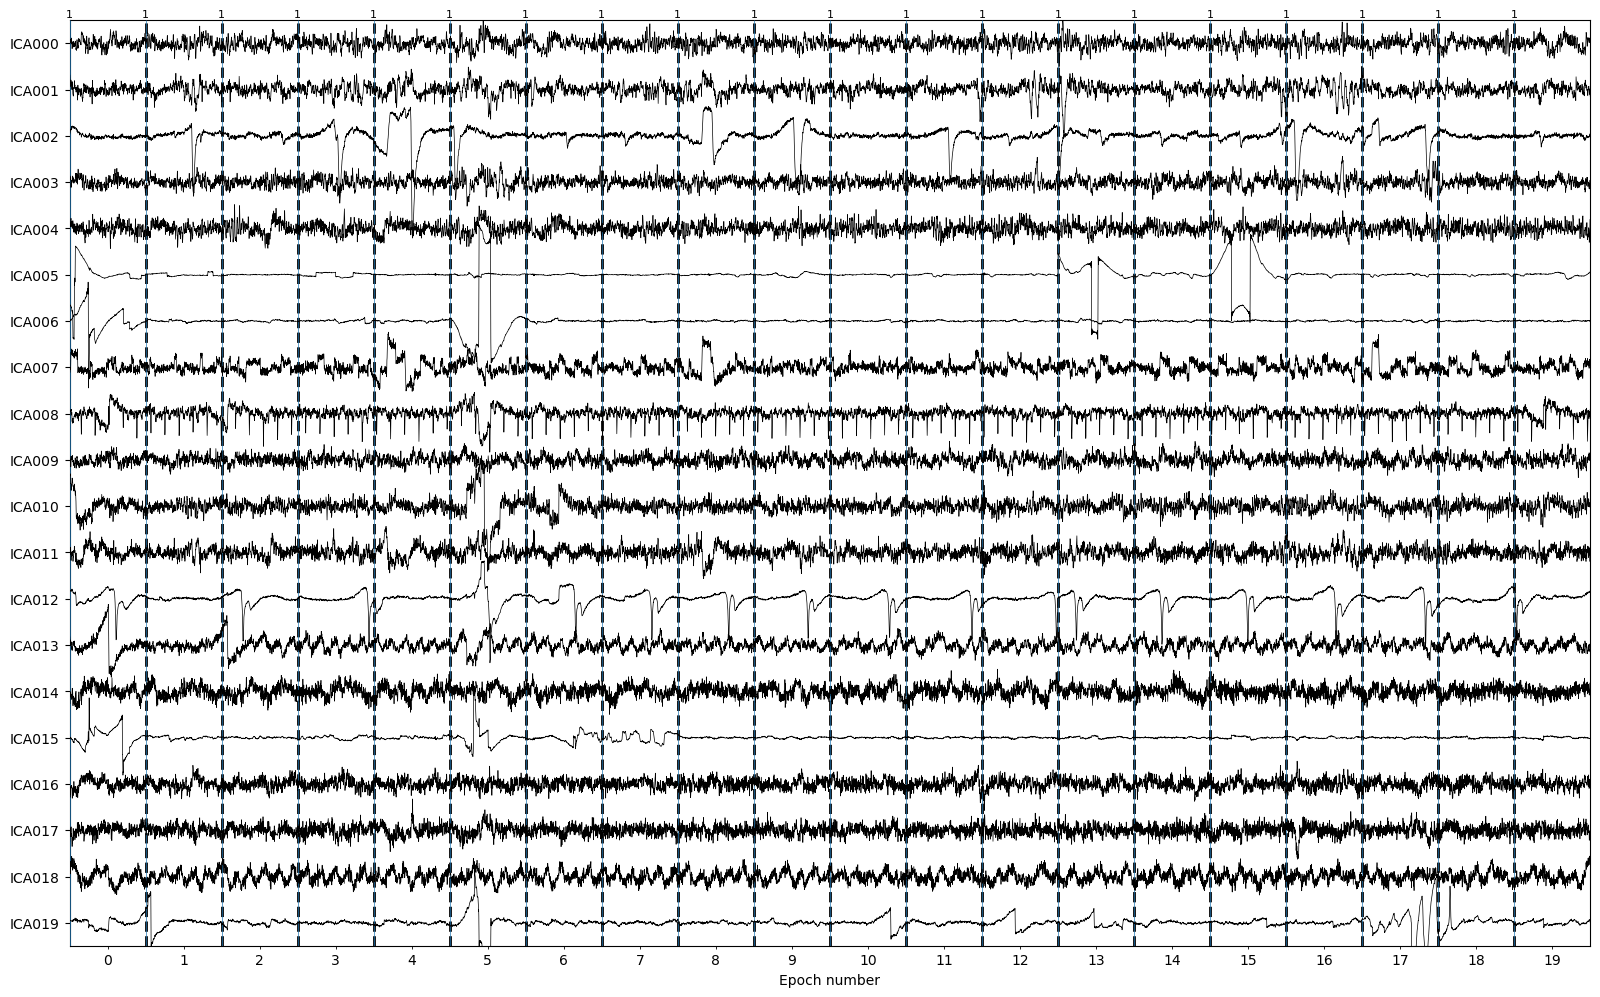

Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


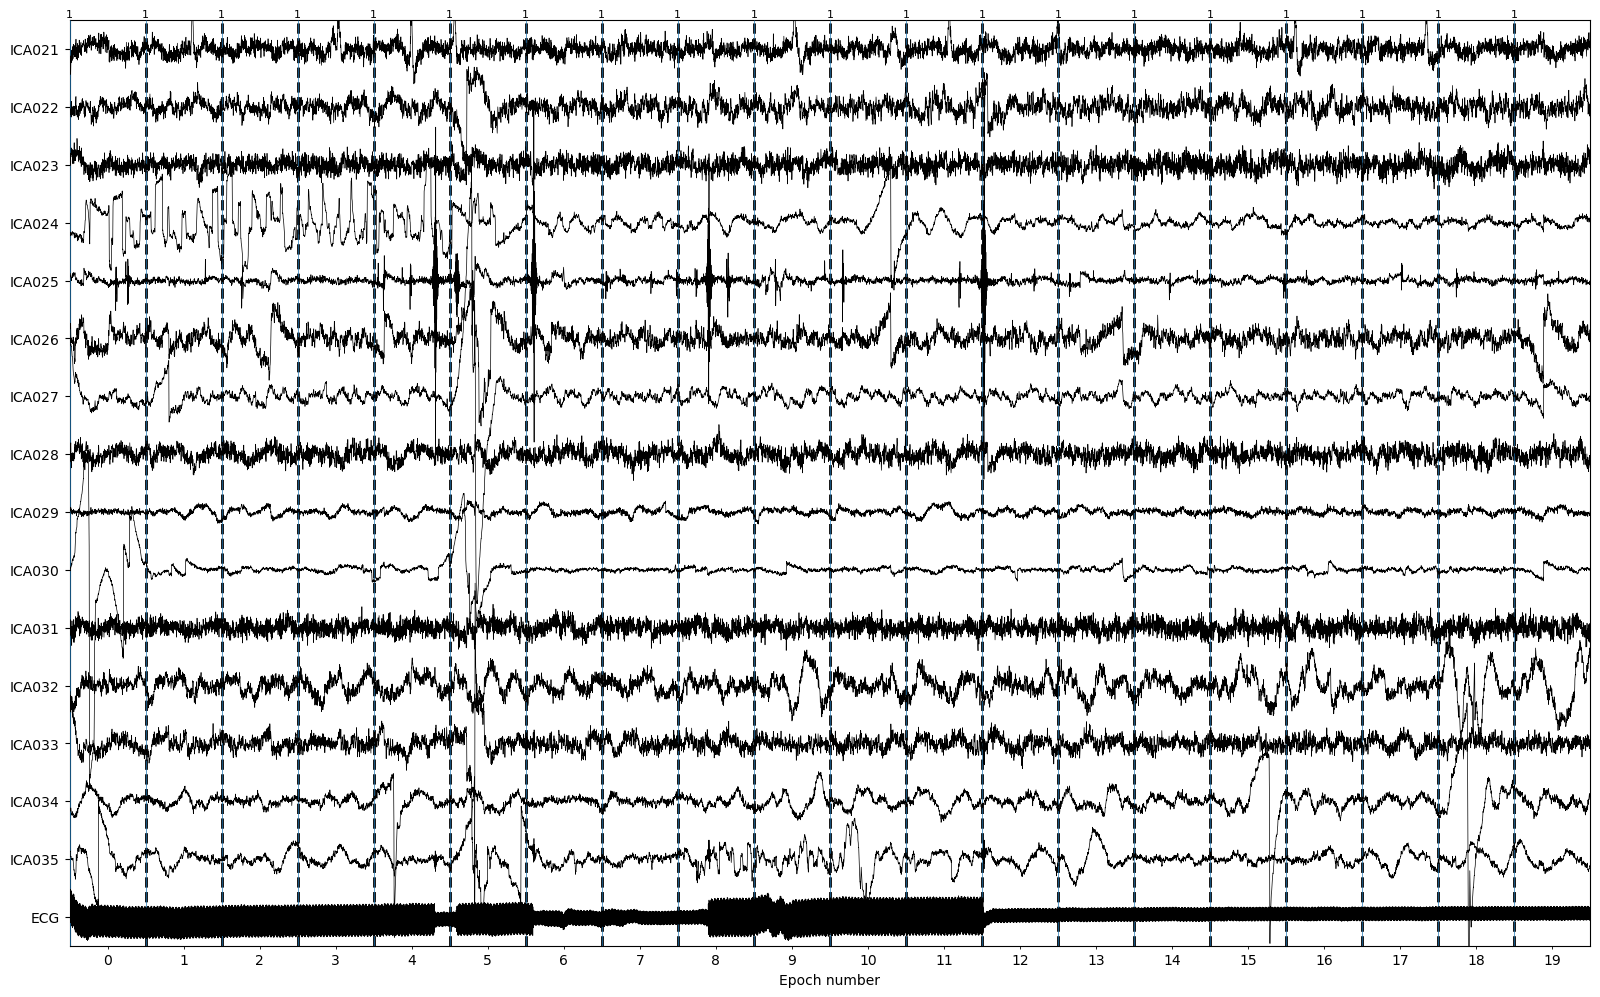

In [45]:
ica_plot1 = ica.plot_sources(
    epochs[~reject_log.bad_epochs], show_scrollbars=False, picks=slice(0, 20)
)
ica_plot2 = ica.plot_sources(
    epochs[~reject_log.bad_epochs], show_scrollbars=False, picks=slice(21, 40)
)
ica.exclude = [2, 5, 6, 8, 12, 15, 19, 24, 25, 30, 32, 34, 35]

In [46]:
epochs_clean = ica.apply(epochs, exclude=ica.exclude)
ar = autoreject.AutoReject(
    n_interpolate=[1, 2, 4, 8, 16, 32, 64, 128], random_state=11, n_jobs=1, verbose=True
)
ar.fit(epochs_clean)  # fit on a few epochs to save time
epochs_clean_ar, reject_clean_log = ar.transform(epochs, return_log=True)

Applying ICA to Epochs instance
    Transforming to ICA space (36 components)
    Zeroing out 13 ICA components
    Projecting back using 256 PCA components
Running autoreject on ch_type=eeg


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/autoreject/utils.py:73: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Creating augmented epochs : 0/256 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/256 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/8 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=32


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/autoreject/utils.py:73: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Repairing epochs : 0/75 [00:00<?,       ?it/s]

Dropped 13 epochs: 0, 14, 15, 33, 34, 35, 54, 55, 64, 66, 72, 73, 74


No projector specified for this dataset. Please consider the method self.add_proj.


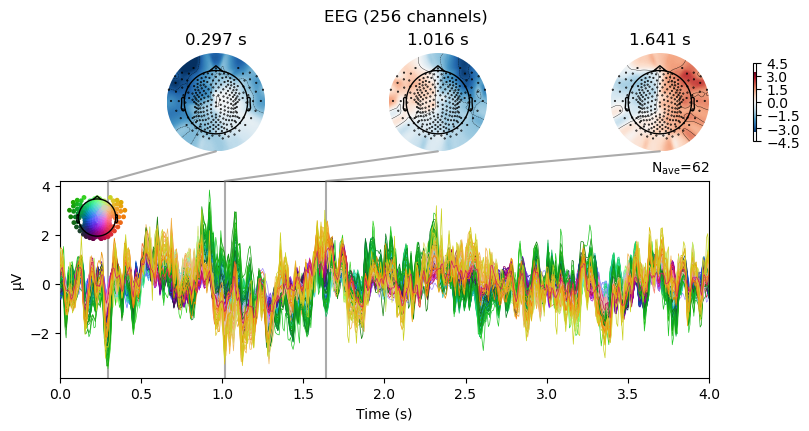

Effective window size : 4.008 (s)
Averaging across epochs...


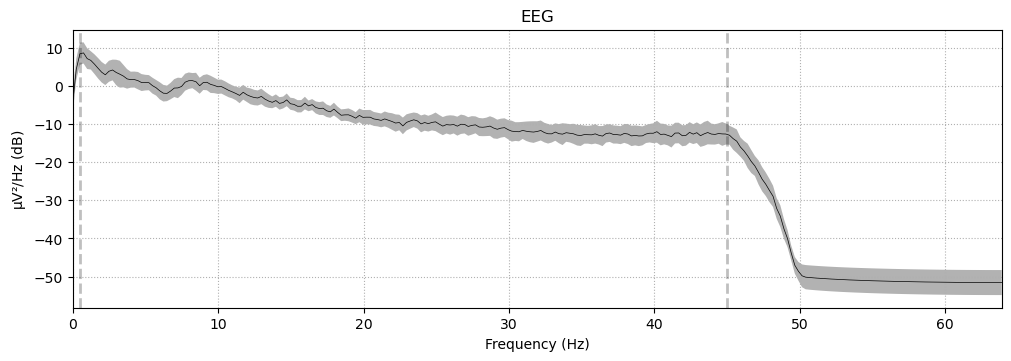

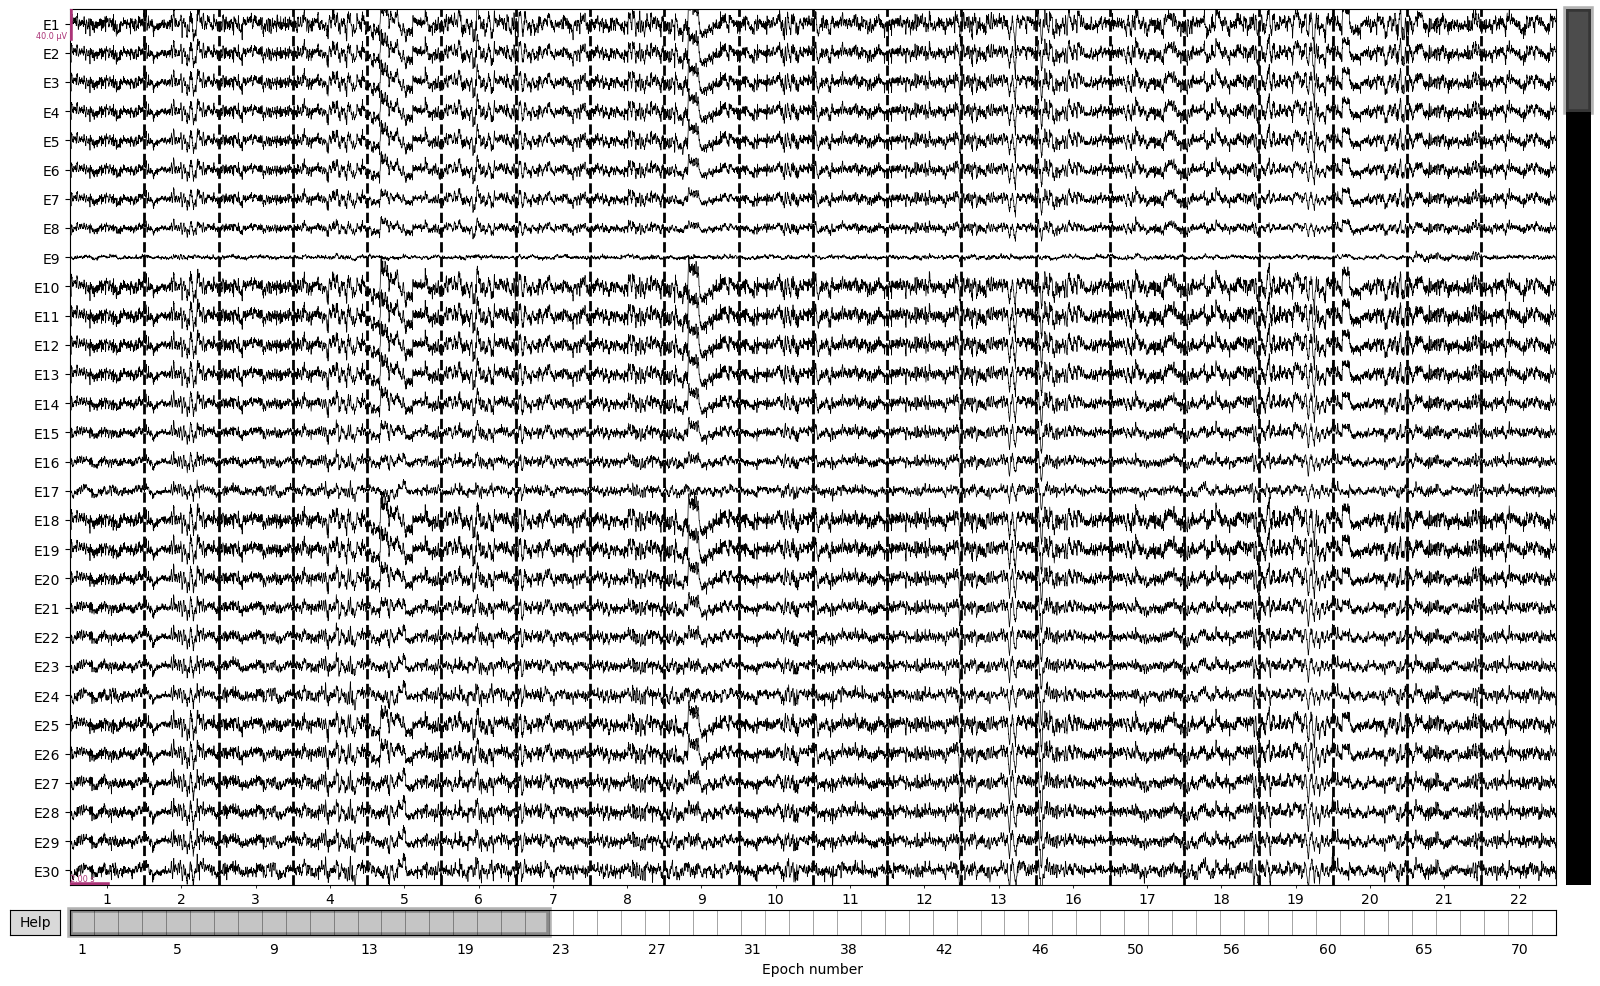

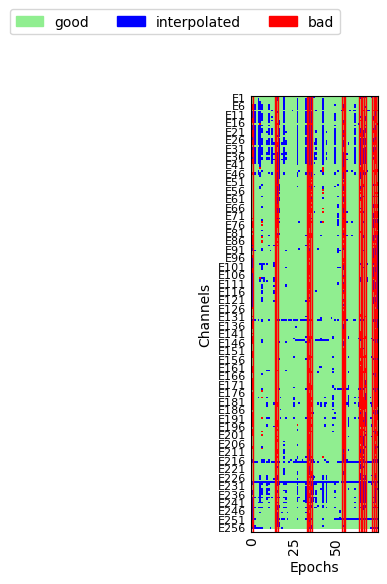

In [48]:
epoch_ar_plot = epochs_clean_ar.copy().average().detrend().plot_joint()
epochs_ar_psd = epochs_clean_ar.compute_psd(
    method="welch", picks="eeg", exclude="bads"
).plot(average=True, picks="eeg", exclude="bads", show=False)
epochs_raw = epochs_clean_ar.plot(n_epochs=20, n_channels=30, scalings=dict(eeg=20e-6))
reject_plot = reject_log.plot(orientation="horizontal")